Import:

In [18]:
import numpy as np
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
#import seaborn as sns
from random import gauss

Parameters:

In [26]:
# Total population, N.
N = 8.5*10**6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 246, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
D0 = 0 #no death at t0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.4/11, 1./11 #multiplied by 36 
print("R_0 =", beta/gamma)

#mortality rate
m = 3./100

#Nb days of simulation
D = 300
time = np.linspace(0, D, D)

#Hospital_capacity
beds = 40000
resp = 777

#Quarantine: isolation of symptomatic people
StartQ = 100 #how many days after 
Quarantine = {"no":0, "yes":0.75} #yes: percentage of sick people showing symptoms
Q = Quarantine["no"]

#Hygiene level
Hygiene = {"dirty":0.5, "normal":1.0, "medium":1.5, "high":2.0} 
current_hygiene = "normal"
h_impact = Hygiene[current_hygiene]
StartH = 80

#Supermarket frequency
shopping_freq = {"very low":1, "low": 2,"normal":3,"high":5,"very high":6,"everyday":7} #number of days you go shopping/week
current_shop = shopping_freq["very low"] #current shopping frequency

#Time out of home

#Social distancing
pop_dist = {"100%":1, "90%":0.9, "75%":0.75, "50%":0.5, "25%":0.25, "0%":0} # % of the population practicing social distancing
level_dist = {"isolation":0, "very high": 1, "high":2, "moderate":4, "low":6, "none":8} #how many ppl you see in 1 day if you are distancing
#radius = 0, r/8, 3*r/8, 5*r/8, r
#beta = 0, b/64, 9*b/64, 25*b/64, b
dist_impact = [pop_dist["0%"],level_dist["none"]]
startD = 50

#Back to normal
DayBTN = float('inf')

R_0 = 2.4


Computation:

In [27]:
#initialize data to plot
S_array = np.ones(D)*S0
I_array = np.ones(D)*I0 
R_array = np.ones(D)*R0
De_array = np.zeros(D)
Severe   = np.zeros(D)
Critical = np.zeros(D)


# The SIRD model differential equations.
def deriv(y, t, N, beta, gamma, day, current_shop): 
    S, I, R, De = y
   
    #risk people
    Severe[day]    = I* 0.15 #require hosp
    Critical[day]  = I* 0.05 #require resp
    
    #quarantined people
    q=0
    if day >= StartQ:
        q = I*Q
    
    #check hospital capacity
    if Critical[day] > resp:
        m_r = 2.5*m
    elif Severe[day]+Critical[i] > beds: 
        m_r = 2*m
    else: m_r = m
    
    #adapt beta to hygien
    if day >= StartH:
        beta = beta/h_impact
        
    #if everything suddenly goes back to normal
    if day >= DayBTN:
        q = 0 #remove quarantine
        I2, beta2 = 0,0 #remove social distancing
        I1 = I
        current_shop = shopping_freq["normal"]  
        
    #adapt beta to supermarket frequency
    beta = beta/2**(np.log(shopping_freq["normal"]/current_shop)/np.log(5)) #everytime shopping freqency is divided by 5, beta/2
   
    #social distancing
    beta2 = 0
    I1 = I
    I2 = 0
    if day >= startD:
        beta2 = beta*dist_impact[1]**2/64. #beta of ppl distancing
        I1 = I*(1-dist_impact[0]) #proportion of infected not distancing
        I2 = I*dist_impact[0] #proportion of ppl distancing
        
    #diff eq
    dSdt = -(beta * S * I1 + beta2 * S * I2 - beta * S * q) / N
    dIdt = (beta * S * I1 + beta2 * S * I2 - beta * S * q)/ N - gamma * I
    dRdt = (1-m_r)*gamma * I
    dDedt = gamma*m_r*I
    
    return dSdt, dIdt, dRdt, dDedt

# Initial conditions vector
t=[0,1]
y0 = S0, I0, R0, D0

# Integrate the SIRD equations over the time grid, t.
for i in range(1,D):
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, i, current_shop))
    
    S, I, R, De = ret.T
    
    S_array[i]   = S[1]
    I_array[i]   = I[1]
    R_array[i]   = R[1]
    De_array[i]  = De[1]
    y0 = S[1], I[1], R[1], De[1]

#get total death and infected
Tot_death = De_array[len(De_array)-1]
Percentage_death = Tot_death/N*100
Tot_infected = R_array[len(R_array)-1]
Percentage_infected = Tot_infected/N*100


Plots

Death:  353797.4935438861
% Death:  4.162323453457484
Infected:  4382185.4661382865
% infected 51.55512313103866


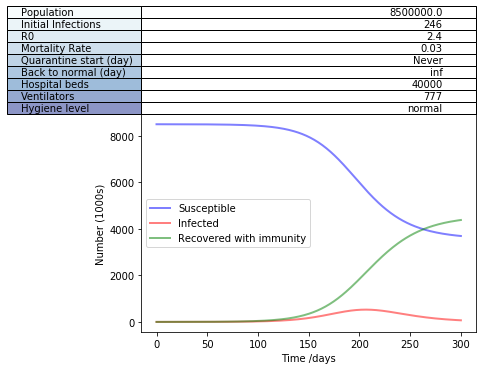

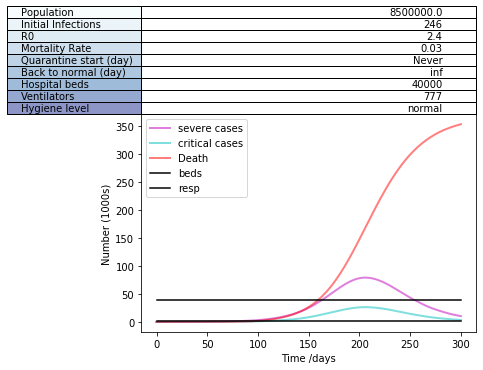

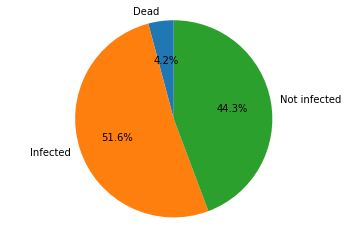

In [28]:
#Info for table
rows = ("Population", "Initial Infections", "R0", "Mortality Rate", "Quarantine start (day)", "Back to normal (day)",
        "Hospital beds", "Ventilators", "Hygiene level")
quarantine_start = "Never"
if Q != 0:
    quarantine_start = StartQ
data = [[N], [I0], [beta/gamma], [m], [quarantine_start], [DayBTN], [beds], [resp], [current_hygiene]]
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))

# Prints
print("Death: ", Tot_death)
print("% Death: ", Percentage_death)
print("Infected: ", Tot_infected)
print("% infected", Percentage_infected)

#plot SIR 
fig1 = plt.figure(facecolor='w')
plt.plot(time, S_array/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(time, I_array/1000, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(time, R_array/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
plt.xlabel('Time /days')
plt.ylabel('Number (1000s)')

plt.table(cellText=data, rowLabels=rows, rowColours=colors, loc='top')
legend = plt.legend()
#plt.savefig('NoMesSIR.png', bbox_inches="tight", pad_inches=1)


#Plot deaths and critical
fig2 = plt.figure(facecolor='w')
plt.plot(time, Severe/1000,  'm', alpha=0.5, lw=2, label='severe cases')
plt.plot(time, Critical/1000, 'c', alpha=0.5, lw=2, label='critical cases')
plt.plot(time, De_array/1000, 'r', alpha=0.5, lw=2, label='Death')


plt.plot([0,D], [beds/1000, beds/1000], 'k', label='beds')
plt.plot([0,D], [resp/1000, resp/1000],'k', label='resp')
plt.table(cellText=data, rowLabels=rows, rowColours=colors, loc='top')

plt.xlabel('Time /days')
plt.ylabel('Number (1000s)')
legend = plt.legend()
#plt.savefig('NoMesD.png', bbox_inches="tight", pad_inches=1)


#Pie Chart
labels = 'Dead', 'Infected', 'Not infected'
sizes = [Percentage_death, Percentage_infected, 100-Percentage_death-Percentage_infected]
#explode = (0.1, 0.1, 0)  

fig3, ax3 = plt.subplots()
ax3.pie(sizes, explode=None, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('NoMesPie.png')


plt.show()

In [22]:
Animation (not working yet)

SyntaxError: invalid syntax (<ipython-input-22-ed48dabd5c0c>, line 1)

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

def animate(i):
    data_pd = pd.DataFrame(I_array[1:]).astype(float)
    data_pd.columns = {"time"}
    data =data_pd[:int(i+1)] #select data range
    p = sns.lineplot(x=data.index, y=data["time"], data=data, color="r")
    p.tick_params(labelsize=17)
    plt.setp(p.lines,linewidth=7)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=17, repeat=True)
ani.save('TestAnim.mp4', writer=writer)